# 2018.11.01: Network inference from time series of cartegorical variables
## Vipul's update

In [1]:
import sys,os
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# setting parameter:
np.random.seed(1)

n = 10 # number of positions
m = 5 # number of values at each position
l = 4*((n*m)**2) # number of samples
#l = 500

g = 1.

In [3]:
def itab(n,m):    
    i1 = np.zeros(n)
    i2 = np.zeros(n)
    for i in range(n):
        i1[i] = i*m
        i2[i] = (i+1)*m

    return i1.astype(int),i2.astype(int)

i1tab,i2tab = itab(n,m)

In [4]:
# generate coupling matrix w0:
def generate_coupling(n,m,g):
    nm = n*m
    w = np.random.normal(0.0,g/np.sqrt(nm),size=(nm,nm))
    
    for i in range(n):
        i1,i2 = i1tab[i],i2tab[i]
        w[i1:i2,:] -= w[i1:i2,:].mean(axis=0)            

    for i in range(n):
        i1,i2 = i1tab[i],i2tab[i]
        w[:,i1:i2] -= w[:,i1:i2].mean(axis=1)[:,np.newaxis]            
        
    return w

In [5]:
w0 = generate_coupling(n,m,g)

In [6]:
# 2018.10.27: generate time series by MCMC
def generate_sequences_MCMC(w,n,m,l): 
    #print(i1tab,i2tab)
    
    # initial s (categorical variables)
    s_ini = np.random.randint(0,m,size=(l,n)) # integer values
    #print(s_ini)

    # onehot encoder 
    enc = OneHotEncoder(n_values=m)
    s = enc.fit_transform(s_ini).toarray()
    #print(s) 

    ntrial = 100

    for t in range(l-1):
        h = np.sum(s[t,:]*w[:,:],axis=1)
        for i in range(n):
            i1,i2 = i1tab[i],i2tab[i]
                
            k = np.random.randint(0,m)              
            for itrial in range(ntrial):            
                k2 = np.random.randint(0,m)                
                while k2 == k:
                    k2 = np.random.randint(0,m)
                               
                if np.exp(h[i1+k2]- h[i1+k]) > np.random.rand():
                    k = k2
            
            s[t+1,i1:i2] = 0.
            s[t+1,i1+k] = 1.
            
    return s            

In [7]:
s = generate_sequences_MCMC(w0,n,m,l) 

In [8]:
#print(s[:5])

In [9]:
# recover s0 from s
s0 = np.argmax(s.reshape(-1,m),axis=1).reshape(-1,n)

In [10]:
def eps_ab_func(s0,m):
    l,n = s0.shape
    eps = np.zeros((n,l-1,m,m))
    eps[:,:,:] = -1.
    for i in range(n):
        for t in range(l-1):            
            #eps[i,t,:,int(s0[t+1,i])] = -1.
            eps[i,t,int(s0[t+1,i]),:] = 1.
    return eps

In [11]:
eps_ab_all = eps_ab_func(s0,m)

In [12]:
def fit_vp_update(s):
    l = s.shape[0]

    s_av = np.mean(s[:-1],axis=0)
    ds = s[:-1] - s_av
    c = np.cov(ds,rowvar=False,bias=True)
    #print(c)

    c_inv = linalg.pinv(c,rcond=1e-15)
    #print(c_inv)

    nm = n*m
    nloop = 100

    wini = np.random.normal(0.0,g/np.sqrt(nm),size=(nm,nm))

    w_infer = np.zeros((nm,nm))

    for i in range(n):
        i1,i2 = i1tab[i],i2tab[i]

        w = wini[i1:i2,:].copy()
        for iloop in range(nloop):
            h = np.dot(s[:-1],w.T)

            for ia in range(m):
                #dhds_av = np.zeros((m,nm))
                wa = np.zeros(nm)
                
                for ib in range(m):
                    if ib != ia:
                        # eps[t] = s[t+1,ia] - s[t+1,ib] 
                        eps = s[1:,i1+ia] - s[1:,i1+ib]

                        which_ab = eps!=0.

                        eps = eps[which_ab]

                        x = s[:-1]
                        sab = x[which_ab]
                        
                        # ----------------------------
                        sab_av = np.mean(sab,axis=0)
                        dsab = sab - sab_av
                        cab = np.cov(dsab,rowvar=False,bias=True)
                        cab_inv = linalg.pinv(cab,rcond=1e-15)
                        #print(c_inv)
                        
                        # ----------------------------
                        
                        h_ab = h[which_ab,ia] - h[which_ab,ib]

                        ha = eps*h_ab/np.tanh(h_ab/2.)

                        dhds = (ha - ha.mean())[:,np.newaxis]*dsab

                        dhds_av = dhds.mean(axis=0)
                        
                        wa += np.dot(cab_inv,dhds_av) # ???

                w[ia,:] = wa/m

        w_infer[i1:i2,:] = w     

    return w_infer

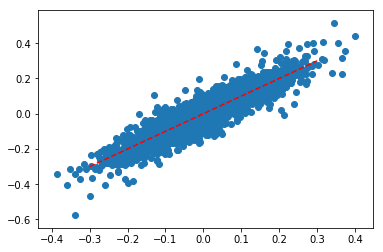

In [13]:
w = fit_vp_update(s)

plt.scatter(w0,w)
plt.plot([-0.3,0.3],[-0.3,0.3],'r--')

In [14]:
mse = ((w0-w)**2).mean()
print('mse:',mse)

('mse:', 0.0026858025535562184)
